# COVID-19 Data Processing and Analysis
This notebook processes COVID-19 datasets, including loading, profiling, cleaning, transforming, and visualizing data for both US and global datasets.

In [3]:
%pip install geopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.4/125.4 kB 229.9 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 1.0 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import numpy as np
import time
import logging
import re
from multiprocessing import Pool
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from io import StringIO
from geopy.geocoders import Nominatim
import sqlite3
import os
from io import StringIO


# Retrieve environment variables
workspace = os.getenv('WORKSPACE', '/home/jovyan/notebooks/dataset_study&preparation/')
geonames_path = os.getenv('GEONAMES_PATH', '/home/jovyan/notebooks/dataset_study&preparation/utils/geonames/allCountries/allCountries_Lat_Long.csv')


# Configure logging
# Capture logs in the notebook
class NotebookLogger(logging.Handler):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.log_output = widgets.Output(layout={'border': '1px solid black'})
    
    def emit(self, record):
        log_entry = self.format(record)
        with self.log_output:
            print(log_entry)
    
    def clear(self):
        self.log_output.clear_output()

# Initialize the notebook logger
notebook_logger = NotebookLogger()
logging.getLogger().addHandler(notebook_logger)
logging.getLogger().setLevel(logging.INFO)

## Widgets

In [5]:

# Configuration
config = {
    'topic': 'deaths',  # 'deaths' or 'confirmed_cases'
    'loc': 'us',  # 'us' or 'global'
    'agg': 'M',  # 'M' for monthly, 'Y' for yearly
    'geonames_path': os.path.join(geonames_path),
    'original_dataset_path': os.path.join(workspace, 'RAW_us_deaths.csv'),
    'cleaned_dataset_path': os.path.join(workspace, 'CLEANED_us_deaths.csv'),
    'transformed_dataset_path': os.path.join(workspace, 'TRANSFORMED_M_us_deaths.csv'),
    'do_profiling': True
}

# Create widgets for interactive configuration
topic_widget = widgets.Dropdown(
    options=['deaths', 'confirmed_cases'],
    value='deaths',
    description='Topic:',
)

loc_widget = widgets.Dropdown(
    options=['us', 'global'],
    value='us',
    description='Location:',
)

agg_widget = widgets.Dropdown(
    options=['M', 'Y'],
    value='M',
    description='Aggregation:',
)

profiling_checkbox = widgets.Checkbox(
    value=True,
    description='Data Profiling'
)

processing_checkbox = widgets.Checkbox(
    value=False,
    description='Data Processing'
)

def on_profiling_checkbox_change(change):
    if change['new']:
        processing_checkbox.value = False

def on_processing_checkbox_change(change):
    if change['new']:
        profiling_checkbox.value = False

profiling_checkbox.observe(on_profiling_checkbox_change, names='value')
processing_checkbox.observe(on_processing_checkbox_change, names='value')

submit_button = widgets.Button(
    description='Submit',
    button_style='success',
)

loading_bar = widgets.IntProgress(
    value=0,
    min=0,
    max=100,
    step=1,
    description='Loading:',
    bar_style='info',
    orientation='horizontal'
)

loading_bar.layout.visibility = 'hidden'



## Functions

In [6]:
def load_data(path):
    logging.info(f"Loading data from {path}")
    return pd.read_csv(path)

def data_profiling(df, output_path, filename):
    logging.info("Profiling data")
    html_content = '''
    <html>
    <head>
        <title>Data Profiling Results</title>
        <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/4.5.2/css/bootstrap.min.css">
        <style>
            body { font-family: Arial, sans-serif; margin: 20px; }
            h1, h2 { margin-top: 20px; }
            .table { width: 100%; margin-bottom: 20px; }
            .container { max-width: 1200px; margin: auto; }
        </style>
    </head>
    <body>
    <div class="container">
    '''
    html_content += f'<h1>Data Profiling Results for {filename}</h1>'

    html_content += '<h2>Head of the DataFrame</h2>'
    html_content += df.head().to_html(classes='table table-striped')

    html_content += '<h2>Shape of the DataFrame</h2>'
    html_content += '<p>Shape: {}</p>'.format(df.shape)

    html_content += '<h2>Info of the DataFrame</h2>'
    buffer = StringIO()
    df.info(buf=buffer)
    info_text = buffer.getvalue().replace('\n', '<br>')
    html_content += '<p>{}</p>'.format(info_text)

    html_content += '<h2>Description of the DataFrame</h2>'
    html_content += df.describe().to_html(classes='table table-striped')

    html_content += '<h2>Columns with Null Values</h2>'
    null_columns = df.columns[df.isnull().any()].tolist()
    html_content += '<p>{}</p>'.format(', '.join(null_columns))

    html_content += '<h2>Data Types</h2>'
    html_content += '<p>{}</p>'.format(df.dtypes.to_string().replace('\n', '<br>'))

    html_content += '</div></body></html>'

    with open(output_path, 'w') as f:
        f.write(html_content)

def clean_data_us(df):
    logging.info("Cleaning US data")
    # Convert relevant columns to 'category' dtype before handling null values
    if 'Admin2' in df.columns:
        df['Admin2'] = df['Admin2'].astype('category')
    
    if 'FIPS' in df.columns:
        df['FIPS'] = df['FIPS'].astype('float')

    # Handling null values
    if 'Admin2' in df.columns:
        if 'Unknown' not in df['Admin2'].cat.categories:
            df['Admin2'] = df['Admin2'].cat.add_categories('Unknown')
        df['Admin2'] = df['Admin2'].fillna('Unknown')

    if 'FIPS' in df.columns:
        median_fips = df['FIPS'].median()
        df['FIPS'] = df['FIPS'].fillna(median_fips)

    return df


def clean_data_global(df, geonames_path):
    logging.info("Cleaning global data")

    # Convert relevant columns to appropriate dtypes
    cat_cols = list(df.columns[:2])
    df[cat_cols] = df[cat_cols].astype('category')

    float_cols = list(df.columns[2:4])
    df[float_cols] = df[float_cols].astype('float')

    date_cols = df.columns[4:]
    df[date_cols] = df[date_cols].astype('int')

    # Handle missing values
    if 'Province/State' in df.columns:
        if 'Unknown' not in df['Province/State'].cat.categories:
            df['Province/State'] = df['Province/State'].cat.add_categories('Unknown')
        df['Province/State'] = df['Province/State'].fillna('Unknown')

    if 'Country/Region' in df.columns:
        if 'Unknown' not in df['Country/Region'].cat.categories:
            df['Country/Region'] = df['Country/Region'].cat.add_categories('Unknown')
        df['Country/Region'] = df['Country/Region'].fillna('Unknown')

    # Load the GeoNames data into a DataFrame
    geonames_df = pd.read_csv(geonames_path, sep=',')

    # Create SQLite database and load data
    conn = sqlite3.connect('geolocation.db')
    geonames_df[['Latitude', 'Longitude', 'Country_Name']].to_sql('geolocation', conn, if_exists='replace', index=False)
    conn.close()

    # Check if 'Lat' and 'Long' columns exist before proceeding
    if 'Lat' in df.columns and 'Long' in df.columns:
        # Geocode missing latitude and longitude using local SQLite database
        conn = sqlite3.connect('geolocation.db')

        def query_location(name):
            query = "SELECT Latitude, Longitude FROM geolocation WHERE Country_Name = ? LIMIT 1"
            result = pd.read_sql_query(query, conn, params=(name,))
            if not result.empty:
                return result.iloc[0]['Latitude'], result.iloc[0]['Longitude']
            else:
                return None, None

        def geocode_location(row):
            lat, long = query_location(row['Country/Region'])
            if lat is not None and long is not None:
                return pd.Series([lat, long], index=['Lat', 'Long'])
            else:
                logging.warning(f"Geocoding failed for: {row['Country/Region']}")
                return pd.Series([np.nan, np.nan], index=['Lat', 'Long'])

        missing_lat_long = df[df['Lat'].isnull()]
        geocoded_values = missing_lat_long.apply(geocode_location, axis=1)
        df.loc[missing_lat_long.index, ['Lat', 'Long']] = geocoded_values

        conn.close()
    else:
        logging.warning("Columns 'Lat' and 'Long' are not present in the DataFrame.")

    return df

def process_data(config):
    # Load the dataset
    df = pd.read_csv(config['dataset_path'])
    
    # Print column names for debugging
    print("Column names:", df.columns)
    
    # Check if 'Country/Region' is in the columns
    if 'Country/Region' not in df.columns:
        raise KeyError("'Country/Region' column not found in the dataset")
    
    # Proceed with cleaning data
    if config['data_scope'] == 'us':
        df = clean_data_us(df)
    else:
        df = clean_data_global(df, config['geonames_path'])
    
    save_data(df, config['cleaned_dataset_path'])

def save_data(df, path):
    logging.info(f"Saving data to {path}")
    df.to_csv(path, index=False)

def transform_data(df, loc, topic, agg):
    logging.info("Transforming data")
    # Identify non-date and date columns dynamically
    non_date_cols = [col for col in df.columns if not re.match(r'\d{1,2}/\d{1,2}/\d{2,4}', col)]
    date_cols = [col for col in df.columns if re.match(r'\d{1,2}/\d{1,2}/\d{2,4}', col)]
    
    # Convert date columns to datetime format
    df_dates = df[date_cols].T
    df_dates.index = pd.to_datetime(df_dates.index, errors='coerce')
    
    # Resample and aggregate by the specified frequency
    df_dates = df_dates.groupby(df_dates.index.to_period(agg)).sum()
    
    # Transpose back to the original layout
    df_dates = df_dates.T
    df_dates.columns = df_dates.columns.strftime(f'Total_{topic}_%Y-%m')
    
    # Combine non-date and date columns
    df_transformed = pd.concat([df[non_date_cols], df_dates], axis=1)
    return df_transformed

def process_data(config):
    df = load_data(config['original_dataset_path'])
    
    if config['do_profiling']:
        data_profiling(df, 'Data_Profiling_Results.html', config['original_dataset_path'])
    
    if config['loc'] == 'us':
        df = clean_data_us(df)
    else:
        df = clean_data_global(df, config['geonames_path'])
    
    save_data(df, config['cleaned_dataset_path'])
    df = transform_data(df, config['loc'], config['topic'], config['agg'])
    save_data(df, config['transformed_dataset_path'])

def update_config(topic, loc, agg, do_profiling, do_processing):
    config['topic'] = topic
    config['loc'] = loc
    config['agg'] = agg
    config['do_profiling'] = do_profiling
    config['original_dataset_path'] = os.path.join(workspace, f'RAW_{loc}_{topic}.csv')
    config['cleaned_dataset_path'] = os.path.join(workspace, f'CLEANED_{loc}_{topic}.csv')
    config['transformed_dataset_path'] = os.path.join(workspace, f'TRANSFORMED_{agg}_{loc}_{topic}.csv')

loading_bar.layout.visibility = 'hidden'    
    
def on_submit(b):
    notebook_logger.clear()
    clear_output(wait=True)
    update_config(topic_widget.value, loc_widget.value, agg_widget.value, profiling_checkbox.value, processing_checkbox.value)
    loading_bar.layout.visibility = 'visible'  # Show the progress bar
    display(ui)
    display(notebook_logger.log_output)
    loading_bar.value = 0
    loading_bar.bar_style = 'info'
    profiling_result_link = None
    if profiling_checkbox.value:
        logging.info(f"Profiling file: {config['original_dataset_path']}")
        loading_bar.value = 20
        df = load_data(config['original_dataset_path'])
        data_profiling(df, 'Data_Profiling_Results.html', config['original_dataset_path'])
        profiling_result_link = HTML('<a href="Data_Profiling_Results.html" target="_blank">View Data Profiling Results</a>')
        loading_bar.value = 100
        loading_bar.bar_style = 'success'
    if processing_checkbox.value:
        with tqdm(total=80) as pbar:
            pbar.update(20)
            loading_bar.value = 40
            process_data(config)
            pbar.update(60)
            loading_bar.value = 100
            loading_bar.bar_style = 'success'
    if loading_bar.value == 100:
        time.sleep(2)  # Wait for 2 seconds before hiding the progress bar
    loading_bar.layout.visibility = 'hidden'  # Hide the progress bar again after processing
    if profiling_result_link:
        display(profiling_result_link)

submit_button.on_click(on_submit)


## Configurable Parameters
Use the widgets below to change the configuration for processing different datasets. You can choose to perform data profiling, data processing, or both. Click the submit button to apply the chosen parameters and start the process.

In [7]:
# Display widgets and bind the function
ui = widgets.VBox([topic_widget, loc_widget, agg_widget, profiling_checkbox, processing_checkbox, submit_button, loading_bar])
display(ui)
display(notebook_logger.log_output)

Output(layout=Layout(border_bottom='1px solid black', border_left='1px solid black', border_right='1px solid b…

## Data Visualization
Visualize the transformed data to gain insights into the trends over time.

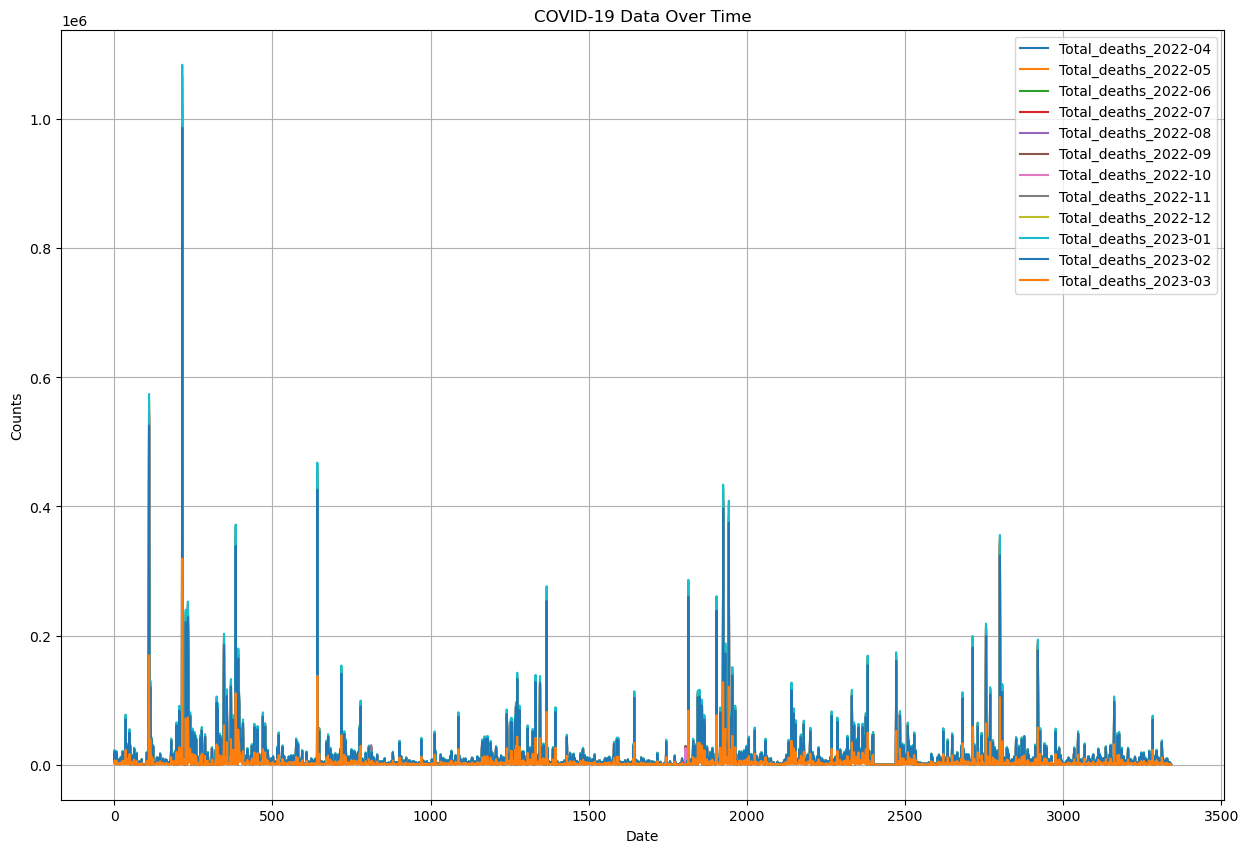

In [19]:
def plot_data(df, columns):
    df[columns].plot(kind='line', figsize=(15, 10))
    plt.title('COVID-19 Data Over Time')
    plt.xlabel('Date')
    plt.ylabel('Counts')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

# Example usage
df_transformed = pd.read_csv(config['transformed_dataset_path'])
plot_data(df_transformed, df_transformed.columns[-12:])
